### Import libraries, load model...

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import argparse
from torch.serialization import save
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt

from kmembert.models import HealthBERT
from kmembert.utils import create_session

In [2]:
# Import argparse
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-d", "--data_folder", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-p", "--path_dataset", type=str, default="data/ehr/test.csv", 
    help="data path to access to the testing file")
parser.add_argument("-r", "--resume", type=str, default="kmembert-base", 
    help="result folder in with the saved checkpoint will be reused")
parser.add_argument("-nr", "--nrows", type=int, default=10, 
    help="maximum number of samples for testing")
parser.add_argument("-f", "--folder_to_save", type=str, default="graphs", 
    help="folder to save the figures")
parser.add_argument("-ng", "--noigr", type=int, default=2, 
    help="The Noigr of a patient")
args = parser.parse_args("")

In [3]:
# Load Model
_, _, device, config = create_session(args)
model = HealthBERT(device, config)

> DEVICE:  cpu
> ROOT:    c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT
> SESSION: c:\Users\DIPIAZZA\Documents\CLBProjet\VirtualMachine_T2\KmemBERT\results\ipykernel_launcher_22-06-16_14h25m53s

Using mode density (Health BERT checkpoint kmembert-base)

Loading camembert and its tokenizer...
if config.resume from health_bert.py
Resuming with model at kmembert-base...
Successfully loaded



### Read data and Select text to study

In [4]:
# Read df used to test
# Creation du jeu de donnees pour retrouver les infos interessantes
test = pd.read_csv("kmembert\\Visualization\\test_VM.csv")

# Read df with prediction
res_pred = pd.read_csv("kmembert\\Visualization\\results_pred_VM.csv")

# Merge 2 dataframes
resul_df = pd.merge(test, res_pred, left_on="indice", right_on="ind")[['Noigr', 'Date cr', 'Date deces', 'Texte', 'indice', 'pred', 'lab']]

# Add columns to have absolute error between pred and lab
resul_df['ecart'] = abs(resul_df['pred']-resul_df['lab'])

resul_df['nb_words'] = resul_df['Texte'].apply(lambda x: len(x.split()))

resul_df['nb_docs'] = resul_df.groupby(["Noigr"])["Noigr"].transform("count")

resul_df = resul_df.sort_values("ecart", ascending=False)

In [53]:
from kmembert.utils import label_to_time_survival
label_to_time_survival(0.063, 800)

52.05759739497184

In [31]:
# Select Noigr Indice's CR to select text to study
id_noigr = 8625409
id_indice = 6140

# Create a list texts_to_classify which contains CR texts to classify
texts_to_classify = resul_df[(resul_df.Noigr==id_noigr) & (resul_df.indice<=id_indice) & (resul_df.indice>id_indice-4)].sort_values("indice").Texte.values
import math
n_max = 1200
for i in range(len(texts_to_classify)):
    if(len(texts_to_classify[i])>n_max):
        texts_to_classify[i] = texts_to_classify[i][:n_max]

In [32]:
texts_to_classify

array(["L'introduction des corticoïdes à bonne dose à permis d'effectuer quelques progrès très minimes, le mariage de sa fille étant vendredi on va poursuivre cette augmentation en faisant 250 mg matin et soir jusqu'au vendredi 17 août puis on rediminuera progressivement.",
       "Motif : Suivi médical dans le cadre de l'HAD.   Le patient semble relativement stable. Il communique encore avec son entourage. Par contre d'un point de vue moteur il y a une accentuation des difficultés au domicile pour le lever liée à une hypertonie des membres inférieurs et du bassin. On note qu'il y a eu une chute lors d'une tentative de levé il y a 48 h. On propose donc à l'épouse de modifier le type de hamac pour lever le patient et si la difficulté persiste il faudra insister auprès de son épouse pour un maintien au lit. On décide conjointement avec Madame XXXXXX de poursuivre la corticothérapie car le patient a déjà pu bénéficier du mariage civil de sa fille et le mariage religieux est prévu dans une

In [43]:
# Add text manually
texto = "A noter que durant ces 3 semaines apparition d'une phlébite étendue fémorale droite avec extension au niveau probablement iliaque et poplité droite. Le patient est en cours de traitement actuellement sous INOHEP 0,7 ml avec actuellement disparition de l'œdème du membre inférieur droit et quasi disparition des douleurs.  A noter que l'état neurologique de Monsieur XXXXXX se dégrade actuellement avec une somnolence de plus en plus fréquente et une incompréhension fluctuante mais présente lors des questions simples."
texts_to_classify = np.array([texto])

-------------------------------------------------------------------------------------------------
##### Print with SD

In [44]:
# Print By Mean With Sum as a tick
from collections import OrderedDict

# Read medical vocabulary
import json
f = open("medical_voc/large.json", encoding='utf-8')
dictio = json.load(f)
med_voc = []
for i in range(len(dictio)):
    med_voc.append(dictio[i][0])
################################################################
# Filter on too long docs, otherwise there will not be read
n_max = 1500
# For Loop on text to classify ["text1..", ..., "text4.."]
for i in range(len(texts_to_classify)):
    # If length is too long, select only 1500 first caracters
    if(len(texts_to_classify[i])>n_max):
        n_remove = (len(texts_to_classify[i])-n_max)/2
        texts_to_classify[i] = texts_to_classify[i][n_remove:(n_remove+n_max)]
################################################################
# For each 'clean' text, compute word attributions
word_attributes = []
for ehr in texts_to_classify:
    cls_explainer = SequenceClassificationExplainer(
        model.camembert,
        model.tokenizer)
    word_attributions = cls_explainer(ehr)
    word_attributes+= [dict(word_attributions)]

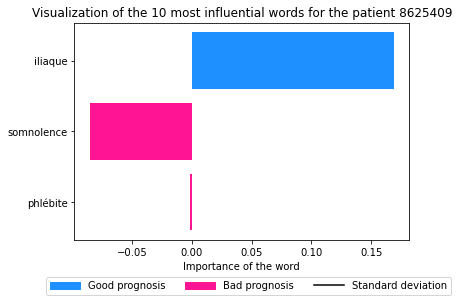

In [45]:
# Compute word importance by sum
result = {}
n_documents = len(word_attributes)
for d in word_attributes:
    for k in d.keys():
        # Si key presente, ajout de la valeur
        if k in result:
            result[k].append(d[k]/n_documents)
        # Sinon, creation de la liste puis ajout de la valeur
        else:
            result[k] = []
            result[k].append(d[k]/n_documents)

# Compute standart deviation for each token
result_sd = {}
for k, v in result.items():
    result_sd[k] = np.std(v)

# Create dict to stock word+attributions for words in medical voc
result_medicam = {}
result_medicam_sd = {}
# For each word of the text to classify
for k, v in result.items():
    # If special character present, replace it with lower case
    new_k = k
    if("▁" in k):
        new_k = k.replace("▁", "").lower()
    elif("_" in k):
        new_k = k.replace("_", "").lower()
    # Add word to dict with transformed string, if in medical voc
    if new_k in med_voc:
        result_medicam[new_k] = v
        result_medicam_sd[new_k] = result_sd[k]
    
# Compute mean of word importance
result_mean = {k: np.mean(result_medicam[k]) for k in result_medicam.keys() & result_medicam}

# Get 10 most important by mean
show_n = 10
final_dict = dict(sorted(result_mean.items(), key=lambda item: abs(item[1]), reverse=True)[:show_n])

# Get 10 most importants word with values as sum
final_dict_sd = dict((k, result_medicam_sd[k]) for k in list(final_dict.keys()))

# BARH Plot with everyword - without filter on medical
show_n = 10
final_dict = dict(sorted(result_mean.items(), key=lambda item: abs(item[1]), reverse=True)[:show_n])
################################################################
# Plot the results for the word attributes (green for positive contribution and red for negative contribution)
x = list(final_dict.keys())
y = list(final_dict.values())
colors = ['deeppink']*show_n 
colors = ['deeppink']*len(y) 
for i in range(len(y)):
    if y[i]>0:
        colors[i] = 'dodgerblue'
fig, ax = plt.subplots()
plt.barh(list(reversed(x)), list(reversed(y)), color=list(reversed(colors)))

i = show_n-1
for k, v in final_dict.items():
    if(final_dict_sd[k] != 0):
        if(v>=0):
            ax.hlines(y=i, xmin=final_dict[k]-final_dict_sd[k], xmax=final_dict[k]+final_dict_sd[k], linewidth=1, colors='black')
            ax.vlines(x=final_dict[k]-final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
            ax.vlines(x=final_dict[k]+final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
        else:
            ax.hlines(y=i, xmin=final_dict[k]-final_dict_sd[k], xmax=final_dict[k]+final_dict_sd[k], linewidth=1, colors='black')
            ax.vlines(x=final_dict[k]-final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
            ax.vlines(x=final_dict[k]+final_dict_sd[k], ymin=i-0.2, ymax=i+0.2, linewidth=1, color='black')
    i -= 1

plt.title(f'Visualization of the 10 most influential words for the patient {id_noigr}')

# Add legend
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
blue_patch = mpatches.Patch(color='dodgerblue')
pink_patch = mpatches.Patch(color='deeppink')
line_b, = plt.plot([0], [0], color='black')

plt.xlabel("Importance of the word")

plt.legend([blue_patch, pink_patch, line_b], 
            ['Good prognosis', 'Bad prognosis', 'Standard deviation'], 
            numpoints=1, handlelength=3,
            loc='lower left',
            bbox_to_anchor=(-0.1, -0.275), ncol=3)

# Save the figure
plt.savefig(f'graphs/interpretation/test_{id_noigr}_boxplotSD.png', bbox_inches='tight')

##### Affichage du texte avec les mots surlignés

In [49]:
# Affichage du texte avec les mots surlignes

# 2 étapes pour afficher le texte surligné:
# ETAPE 1/2 - Creation du dictionnaire result_plot avec, pour chaque token, sa valeur d'importance.
# ETAPE 2/2 - Mise en forme et affichage du texte.
import shap
################################
# ETAPE 1/2 - Creation du dictionnaire result_plot {token: value}.

# Modification du dictionnaire pour afficher les résultats
# Création de 'result_plot' pour stocker tous les mots et leur valeur d'attributions
result_plot = {}
# Pour chaque mot et sa valeur extraite des textes à classifier
# k : le token, v : valeur d'importance du token
for k, v in result.items():
    new_k = k
    #  If special character present, replace it and save with lower case
    if("▁" in k):
        new_k = k.replace("▁", "")
        result_plot[new_k] = 0
    elif("_" in k):
        new_k = k.replace("_", "")
        result_plot[new_k] = 0
    result_plot[new_k] = -v[0] # Negative to adjust shap module, idk why...

################################
# ETAPE 2/2 - Mise en forme et affichage
# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])
################################
# END

In [47]:
texto

"A noter que durant ces 3 semaines apparition d'une phlébite étendue fémorale droite avec extension au niveau probablement iliaque et poplité droite. Le patient est en cours de traitement actuellement sous INOHEP 0,7 ml avec actuellement disparition de l'œdème du membre inférieur droit et quasi disparition des douleurs.  A noter que l'état neurologique de Monsieur XXXXXX se dégrade actuellement avec une somnolence de plus en plus fréquente et une incompréhension fluctuante mais présente lors des questions simples."

In [50]:
result_plot = {key if key != 'moral' else 'fémorale': value for key, value in result_plot.items()}
del result_plot['fé'], result_plot['e']

result_plot = {key if key != 'ité' else 'poplité': value for key, value in result_plot.items()}
del result_plot['pop'], result_plot['l']

result_plot = {key if key != 'IN' else 'INOHEP': value for key, value in result_plot.items()}
del result_plot['OH'], result_plot['EP']

result_plot = {key if key != 'quasi' else 'quasi disparition': value for key, value in result_plot.items()}

result_plot = {key if key != 'ante' else 'fluctuante': value for key, value in result_plot.items()}
del result_plot['f'], result_plot['luc'], result_plot['tu']

# Mise en forme pour affichage
txt = list(result_plot.keys()) # Le texte
txt_data = (list(map(( lambda x: x+' '), txt)),)
val = list(result_plot.values()) # Les valeurs
txt_values = np.array([val])

# Création de l'objet shap et affichage
test = shap._explanation.Explanation(values=txt_values)
test.data = txt_data
test.base_values = np.array([0.])
shap.plots.text(test[0])